In [22]:
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from time import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [23]:
# load the dataset
# the optional parameter: min_faces_per_person: 
# will only retain pictures of people that have at least min_faces_per_person different pictures.
# the optional parameter: resize is the ratio used to resize the each face picture.
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [24]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape
n_samples, h, w

(1288, 50, 37)

In [25]:
# for machine learning we use the data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
y = lfw_people.target
n_features = X.shape[1]

In [26]:
X.shape

(1288, 1850)

'Hugo Chavez'

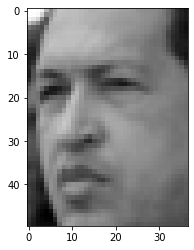

In [27]:
# plot one of the faces
plt.imshow(X[0].reshape((h, w)), cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

'Hugo Chavez'

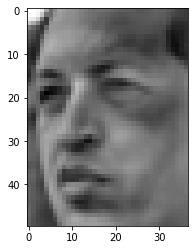

In [28]:
# plot one of the faces after applying a scaling modujle
from sklearn.preprocessing import StandardScaler

plt.imshow(StandardScaler().fit_transform(X)[0].reshape((h, w)), cmap=plt.cm.gray)
lfw_people.target_names[y[0]]

In [29]:
# the label to predict is the id of the person
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [30]:
# let's split our dataset into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

In [31]:

"""
Compute a PCA (eigenfaces) on the face dataset 

from sklearn docs:
The optional parameter whiten=True makes it possible to project the data onto the singular space 
while scaling each component to unit variance. This is often useful if the models down-stream make strong 
assumptions on the isotropy of the signal: this is for example the case for 
Support Vector Machines with the RBF kernel and the K-Means clustering algorithm.
"""

# instantiate the PCA module
pca = PCA(n_components=200, whiten=True)

# create a pipeline called preprocessing that will scale data and then apply PCA
preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca)])

print("Extracting the top %d eigenfaces from %d faces" % (200, X_train.shape[0]))

# fit the pipeline to the training set
preprocessing.fit(X_train)

# grab the PCA from the pipeline
extracted_pca = preprocessing.steps[1][1]

Extracting the top 200 eigenfaces from 966 faces


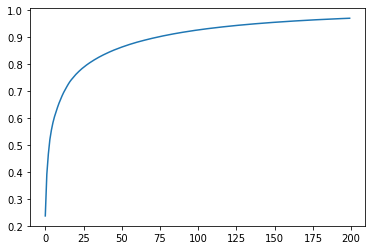

In [32]:
# Scree Plot

plt.plot(np.cumsum(extracted_pca.explained_variance_ratio_))

# starting at 100 components captures over 90% of the variance compared to the 1,850 original features

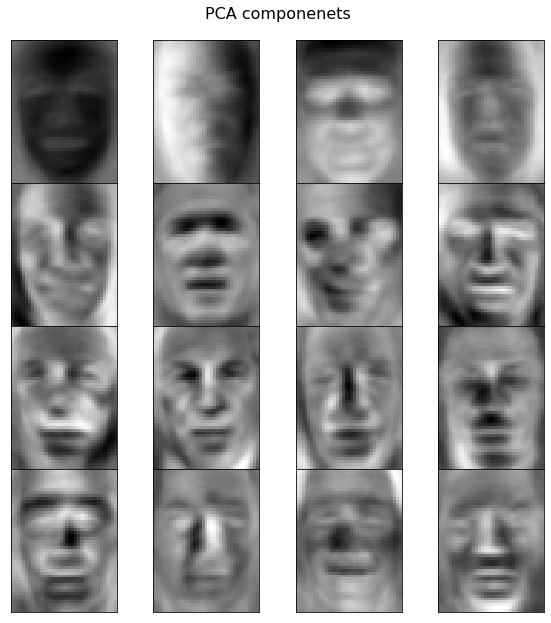

In [33]:
comp = extracted_pca.components_
image_shape = (h, w)
def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()    
plot_gallery('PCA componenets', comp[:16], 4,4)

In [34]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints a more readable confusion matrix with heat labels and options for noramlization
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
# fit without using PCA to see what the difference will be
t0 = time()
logreg = LogisticRegression()

param_grid = {'C': [1e-2, 1e-1,1e0,1e1, 1e2]}
clf = GridSearchCV(logreg, param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# Predicting people's names on the test set
y_pred = best_clf.predict(X_test)

# print((accuracy_score(y_pred, y_test), "Accuracy score for best estimator")
# #classification_report(y_test, y_pred, target_names=target_names)
# print(plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=range(n_classes)), target_names))
# print(round((time() - t0), 1), "seconds to grid search and predict the test set")

/Users/super/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/Users/super/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/super/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/Users/super/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/super/opt/anaconda3/lib/python3.7/site-

In [ ]:
# fit with using PCA to see what the difference will be
t0 = time()

face_pipeline = Pipeline(steps=[('PCA', PCA(n_components=200)), ('logistic', logreg)])

pipe_param_grid = {'logistic__C': [1e-2, 1e-1,1e0,1e1, 1e2]}
clf = GridSearchCV(face_pipeline, pipe_param_grid)
clf = clf.fit(X_train, y_train)
best_clf = clf.best_estimator_

# Predicting people's names on the test set
y_pred = best_clf.predict(X_test)

print accuracy_score(y_pred, y_test), "Accuracy score for best estimator"
print(classification_report(y_test, y_pred, target_names=target_names))
print plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels=range(n_classes)), target_names)
print round((time() - t0), 1), "seconds to grid search and predict the test set"

In [ ]:
# get a list of predicted names and true names to plot with faces in test set
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

# splot a sample of the test set with predicted and true names
plot_gallery(X_test, prediction_titles, h, w)

In [ ]:
def get_best_model_and_accuracy(model, params, X, y):
    grid = GridSearchCV(model,           # the model to grid search
                        params,          # the parameter set to try 
                        error_score=0.)  # if a parameter set raises an error, continue and set the performance as a big, fat 0
    grid.fit(X, y)           # fit the model and parameters
    # our classical metric for performance
    print "Best Accuracy: {}".format(grid.best_score_)
    # the best parameters that caused the best accuracy
    print "Best Parameters: {}".format(grid.best_params_)
    # the average time it took a model to fit to the data (in seconds)
    print "Average Time to Fit (s): {}".format(round(grid.cv_results_['mean_fit_time'].mean(), 3))
    # the average time it took a model to predict out of sample data (in seconds)
    # this metric gives us insight into how this model will perform in real-time analysis
    print "Average Time to Score (s): {}".format(round(grid.cv_results_['mean_score_time'].mean(), 3))

In [ ]:
# Create a larger pipeline to gridsearch
face_params = {'logistic__C':[1e-2, 1e-1, 1e0, 1e1, 1e2], 
               'preprocessing__pca__n_components':[100, 150, 200, 250, 300],
               'preprocessing__pca__whiten':[True, False],
               'preprocessing__lda__n_components':range(1, 7)  
               # [1, 2, 3, 4, 5, 6] recall the max allowed is n_classes-1
              }

pca = PCA()
lda = LinearDiscriminantAnalysis()

preprocessing = Pipeline([('scale', StandardScaler()), ('pca', pca), ('lda', lda)])

logreg = LogisticRegression()
face_pipeline = Pipeline(steps=[('preprocessing', preprocessing), ('logistic', logreg)])

get_best_model_and_accuracy(face_pipeline, face_params, X, y)

In [ ]:
from sklearn.neural_network import BernoulliRBM
from sklearn.preprocessing import MinMaxScaler

In [ ]:
extracted_rbm.components_.shape

In [ ]:
# instantiate the PCA module
rbm = BernoulliRBM(n_components=200, learning_rate=0.01, batch_size=10, n_iter=200, verbose=True)

# create a pipeline called preprocessing that will scale data and then apply PCA
preprocessing = Pipeline([('minmax', MinMaxScaler()), ('rbm', rbm)])

print "Extracting the top %d RBM-faces from %d faces" % (200, X_train.shape[0])

# fit the pipeline to the training set
preprocessing.fit(X_train)

# grab the PCA from the pipeline
extracted_rbm = preprocessing.steps[1][1]

In [ ]:
comp = extracted_rbm.components_
image_shape = (h, w)
def plot_gallery(title, images, n_col, n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,            
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    plt.show()    
plot_gallery('RBM componenets', comp[:16], 4,4)